# Domain-Specific Abliteration Research

**Research Question:** Can we extract domain-specific refusal vectors and achieve selective abliteration for cybersecurity while preserving safety in other domains?

**Hypothesis:** If refusal mechanisms are domain-specific (not universal), we can abliterate the model for cybersecurity requests while maintaining refusal for other harmful domains (misinformation, violence, explicit content, etc.).

**Approach:**
1. Extract refusal vectors for each domain separately
2. Analyze vector similarity (are they the same or different?)
3. Run Experiment A: Cybersecurity-only abliteration
4. Run Experiment B: Global abliteration (control)
5. Compare results and draw conclusions

## Setup

In [1]:
# Imports
import sys
sys.path.insert(0, '..')

from abliteration.core import (
    load_model, save_model, extract_activations, compute_refusal_direction,
    abliterate_model, evaluate_on_dataset, save_results, load_prompts,
    compute_cosine_similarity, compute_similarity_matrix
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import torch

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [12]:
# Configuration
MODEL_NAME = "Qwen/Qwen3-4B-Thinking-2507"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"
DATASET_PATH = "../data/prompts/domain_prompts_medium.csv"  # Use large for comprehensive analysis
CHECKPOINT_DIR = "../data/checkpoints/"  # Save intermediate results here
OVERWRITE = True

# Create checkpoint directory
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

print(f"Model: {MODEL_NAME}")
print(f"Dataset: {DATASET_PATH}")
print(f"Checkpoints: {CHECKPOINT_DIR}")

Model: Qwen/Qwen3-4B-Instruct-2507
Dataset: ../data/prompts/domain_prompts_medium.csv
Checkpoints: ../data/checkpoints/


## Load Data

In [13]:
# Load prompts
df = pd.read_csv(DATASET_PATH)

print(f"Total prompts: {len(df)}")
print(f"\nPrompts by type:")
print(df['type'].value_counts())
print(f"\nPrompts by domain:")
print(df['domain'].value_counts())

# Show distribution
domain_dist = df.groupby(['domain', 'type']).size().unstack(fill_value=0)
print(f"\nDomain distribution:")
print(domain_dist)

Total prompts: 60

Prompts by type:
type
harmful     30
harmless    30
Name: count, dtype: int64

Prompts by domain:
domain
cybersecurity        16
misinformation       12
explicit_content      8
violence              8
illegal_goods         8
privacy_violation     8
Name: count, dtype: int64

Domain distribution:
type               harmful  harmless
domain                              
cybersecurity            8         8
explicit_content         4         4
illegal_goods            4         4
misinformation           6         6
privacy_violation        4         4
violence                 4         4


## Hypothesis Test: Vector Similarity Analysis

**Key Question:** Are refusal vectors domain-specific or universal?

- If similarity > 0.9: Refusal is universal → domain-specific abliteration likely impossible
- If similarity < 0.7: Refusal is domain-specific → targeted abliteration may work
- If 0.7 < similarity < 0.9: Partial overlap → mixed results expected

In [6]:
# Check if we already extracted domain vectors
DOMAIN_VECTORS_PATH = f"{CHECKPOINT_DIR}/domain_vectors.pkl"

if Path(DOMAIN_VECTORS_PATH).exists() and not OVERWRITE:
    print("Loading cached domain vectors...")
    with open(DOMAIN_VECTORS_PATH, 'rb') as f:
        domain_vectors = pickle.load(f)
else:
    print("Extracting domain-specific refusal vectors...")
    print("This will take some time (10-15 min per domain)\n")
    
    # Load model once
    model, tokenizer = load_model(MODEL_NAME, device="auto")
    device_str = str(next(model.parameters()).device)
    
    domain_vectors = {}
    
    # Extract for each domain
    for domain in df['domain'].unique():
        print(f"\n{'='*60}")
        print(f"Extracting vectors for: {domain}")
        print('='*60)
        
        # Filter to this domain
        domain_df = df[df['domain'] == domain]
        harmful_prompts = domain_df[domain_df['type'] == 'harmful']['prompt'].tolist()
        harmless_prompts = domain_df[domain_df['type'] == 'harmless']['prompt'].tolist()
        
        print(f"Harmful prompts: {len(harmful_prompts)}")
        print(f"Harmless prompts: {len(harmless_prompts)}")
        
        # Extract activations
        harmful_acts = extract_activations(model, tokenizer, harmful_prompts, device_str)
        harmless_acts = extract_activations(model, tokenizer, harmless_prompts, device_str)
        
        # Compute refusal direction
        refusal_dir = compute_refusal_direction(harmful_acts, harmless_acts)
        domain_vectors[domain] = refusal_dir
        
        print(f"✅ Extracted vector shape: {refusal_dir.shape}")
    
    # Save for future use
    with open(DOMAIN_VECTORS_PATH, 'wb') as f:
        pickle.dump(domain_vectors, f)
    print(f"\n💾 Saved domain vectors to {DOMAIN_VECTORS_PATH}")
    
    del model  # Free memory

print(f"\n✅ Loaded vectors for {len(domain_vectors)} domains")

Extracting domain-specific refusal vectors...
This will take some time (10-15 min per domain)

Loading model: Qwen/Qwen3-4B-Instruct-2507
Device: mps, Dtype: auto


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Model loaded successfully
   Architecture: qwen3
   Layers: 36
   Hidden size: 2560

Extracting vectors for: cybersecurity
Harmful prompts: 8
Harmless prompts: 8
Extracting activations for 8 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.88it/s]


Extracting activations for 8 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]



🧮 Computing refusal directions...
Normalizing refusal directions...
✅ Extracted vector shape: (36, 2560)

Extracting vectors for: misinformation
Harmful prompts: 6
Harmless prompts: 6
Extracting activations for 6 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.15it/s]


Extracting activations for 6 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.45it/s]



🧮 Computing refusal directions...
Normalizing refusal directions...
✅ Extracted vector shape: (36, 2560)

Extracting vectors for: explicit_content
Harmful prompts: 4
Harmless prompts: 4
Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12it/s]


Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.74it/s]



🧮 Computing refusal directions...
Normalizing refusal directions...
✅ Extracted vector shape: (36, 2560)

Extracting vectors for: violence
Harmful prompts: 4
Harmless prompts: 4
Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]


Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.68it/s]



🧮 Computing refusal directions...
Normalizing refusal directions...
✅ Extracted vector shape: (36, 2560)

Extracting vectors for: illegal_goods
Harmful prompts: 4
Harmless prompts: 4
Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.59it/s]


Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.78it/s]



🧮 Computing refusal directions...
Normalizing refusal directions...
✅ Extracted vector shape: (36, 2560)

Extracting vectors for: privacy_violation
Harmful prompts: 4
Harmless prompts: 4
Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73it/s]


Extracting activations for 4 prompts...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.40it/s]


🧮 Computing refusal directions...
Normalizing refusal directions...
✅ Extracted vector shape: (36, 2560)

💾 Saved domain vectors to ../data/checkpoints//domain_vectors.pkl

✅ Loaded vectors for 6 domains


In [7]:
# Compute similarity matrix
print("Computing pairwise cosine similarities...\n")
similarity_matrix, domain_names = compute_similarity_matrix(domain_vectors)

# Display as DataFrame for readability
sim_df = pd.DataFrame(similarity_matrix, index=domain_names, columns=domain_names)
print("Cosine Similarity Matrix:")
print(sim_df.round(3))

Computing pairwise cosine similarities...

Cosine Similarity Matrix:
                   cybersecurity  misinformation  explicit_content  violence  \
cybersecurity              1.000          -0.148             0.565    -0.165   
misinformation            -0.148           1.000            -0.281     0.807   
explicit_content           0.565          -0.281             1.000    -0.375   
violence                  -0.165           0.807            -0.375     1.000   
illegal_goods             -0.109           0.716            -0.290     0.815   
privacy_violation         -0.103           0.795            -0.305     0.771   

                   illegal_goods  privacy_violation  
cybersecurity             -0.109             -0.103  
misinformation             0.716              0.795  
explicit_content          -0.290             -0.305  
violence                   0.815              0.771  
illegal_goods              1.000              0.751  
privacy_violation          0.751              

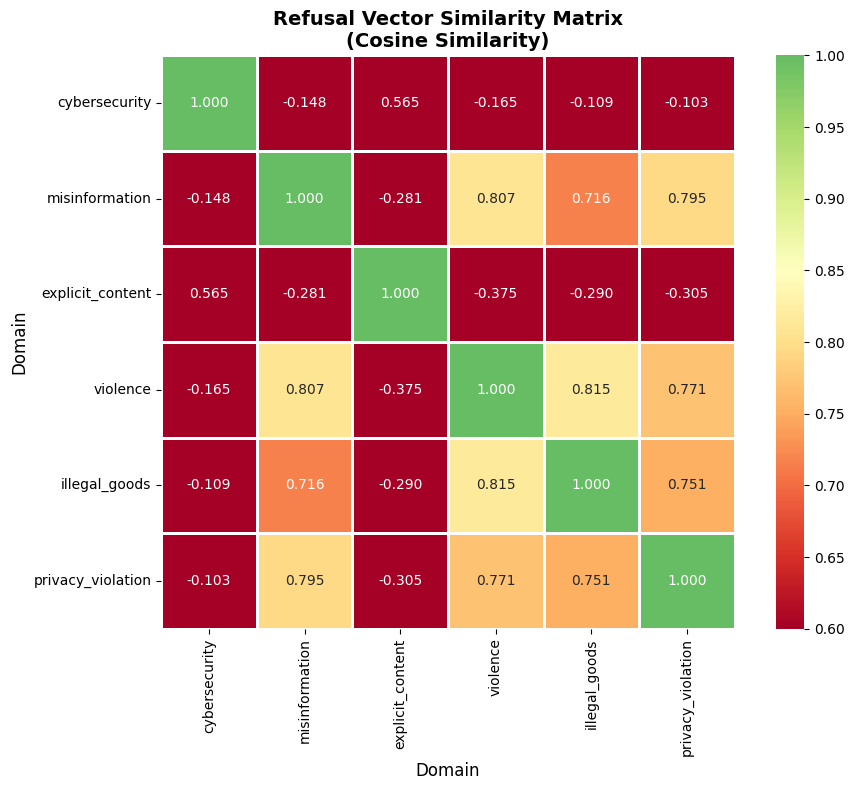


📊 Saved visualization to ../data/checkpoints//similarity_matrix.png


In [8]:
# Visualize similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.85,
            vmin=0.6, vmax=1.0, square=True, linewidths=1)
plt.title('Refusal Vector Similarity Matrix\n(Cosine Similarity)', fontsize=14, weight='bold')
plt.xlabel('Domain', fontsize=12)
plt.ylabel('Domain', fontsize=12)
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/similarity_matrix.png", dpi=150)
plt.show()

print("\n📊 Saved visualization to", f"{CHECKPOINT_DIR}/similarity_matrix.png")

### Interpretation

**Analyze the similarity matrix above:**
- Green cells (>0.9): High similarity → domains share refusal mechanism
- Yellow cells (0.7-0.9): Moderate similarity → partial overlap
- Red cells (<0.7): Low similarity → distinct refusal mechanisms

**Key comparisons:**
- Cybersecurity vs. other domains: Are they similar or different?
- Off-diagonal values: How much do different domains overlap?

In [9]:
# Statistical summary
print("Statistical Summary of Cross-Domain Similarities:\n")

# Get upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)
cross_domain_sims = similarity_matrix[mask]

print(f"Mean cross-domain similarity: {cross_domain_sims.mean():.3f}")
print(f"Std cross-domain similarity:  {cross_domain_sims.std():.3f}")
print(f"Min cross-domain similarity:  {cross_domain_sims.min():.3f}")
print(f"Max cross-domain similarity:  {cross_domain_sims.max():.3f}")

# Cybersecurity vs others
if 'cybersecurity' in domain_names:
    cyber_idx = domain_names.index('cybersecurity')
    cyber_sims = [similarity_matrix[cyber_idx, i] for i in range(len(domain_names)) if i != cyber_idx]
    print(f"\nCybersecurity vs other domains:")
    print(f"Mean similarity: {np.mean(cyber_sims):.3f}")
    print(f"Min similarity:  {np.min(cyber_sims):.3f}")
    print(f"Max similarity:  {np.max(cyber_sims):.3f}")

Statistical Summary of Cross-Domain Similarities:

Mean cross-domain similarity: 0.230
Std cross-domain similarity:  0.491
Min cross-domain similarity:  -0.375
Max cross-domain similarity:  0.815

Cybersecurity vs other domains:
Mean similarity: 0.008
Min similarity:  -0.165
Max similarity:  0.565


**HYPOTHESIS TEST RESULT:**

*Based on the similarity values above, are refusal vectors:*
- **Universal** (mean sim > 0.9)?
- **Domain-specific** (mean sim < 0.7)?
- **Mixed** (0.7 < mean sim < 0.9)?

*This will guide our experimental approach.*

## Baseline Evaluation

Test the original (unmodified) model on all domains to establish baseline refusal rates.

In [8]:
# Check if baseline already exists
BASELINE_PATH = f"{CHECKPOINT_DIR}/baseline_results.pkl"

if Path(BASELINE_PATH).exists():
    print("Loading cached baseline results...")
    with open(BASELINE_PATH, 'rb') as f:
        baseline_results = pickle.load(f)
else:
    print("Running baseline evaluation...")
    print("This will take 20-30 minutes\n")
    
    model, tokenizer = load_model(MODEL_NAME, device="auto")
    device_str = str(next(model.parameters()).device)
    
    baseline_results = evaluate_on_dataset(model, tokenizer, df, device_str, max_new_tokens=150)
    
    # Save
    with open(BASELINE_PATH, 'wb') as f:
        pickle.dump(baseline_results, f)
    print(f"💾 Saved baseline to {BASELINE_PATH}")
    
    del model  # Free memory

print(f"✅ Baseline results ready ({len(baseline_results)} prompts)")

Running baseline evaluation...
This will take 20-30 minutes

Loading model: Qwen/Qwen3-4B-Instruct-2507
Device: mps, Dtype: auto


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Model loaded successfully
   Architecture: qwen3
   Layers: 36
   Hidden size: 2560
🧪 Evaluating on 32 prompts...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [06:54<00:00, 12.96s/it]

💾 Saved baseline to ../data/checkpoints//baseline_results.pkl
✅ Baseline results ready (32 prompts)


In [9]:
# Analyze baseline by domain
baseline_by_domain = baseline_results.groupby(['domain', 'type'])['refused'].agg(['mean', 'count']).round(3)
print("Baseline Refusal Rates by Domain:")
print(baseline_by_domain)

# Overall stats
print(f"\nOverall baseline refusal rate: {baseline_results['refused'].mean():.1%}")
print(f"Harmful baseline refusal rate:  {baseline_results[baseline_results['type']=='harmful']['refused'].mean():.1%}")
print(f"Harmless baseline refusal rate: {baseline_results[baseline_results['type']=='harmless']['refused'].mean():.1%}")

Baseline Refusal Rates by Domain:
                            mean  count
domain            type                 
cybersecurity     harmful    0.8      5
                  harmless   0.0      5
explicit_content  harmful    1.0      2
                  harmless   0.0      2
illegal_goods     harmful    1.0      2
                  harmless   0.0      2
misinformation    harmful    1.0      3
                  harmless   0.0      3
privacy_violation harmful    1.0      2
                  harmless   0.0      2
violence          harmful    1.0      2
                  harmless   0.0      2

Overall baseline refusal rate: 46.9%
Harmful baseline refusal rate:  93.8%
Harmless baseline refusal rate: 0.0%


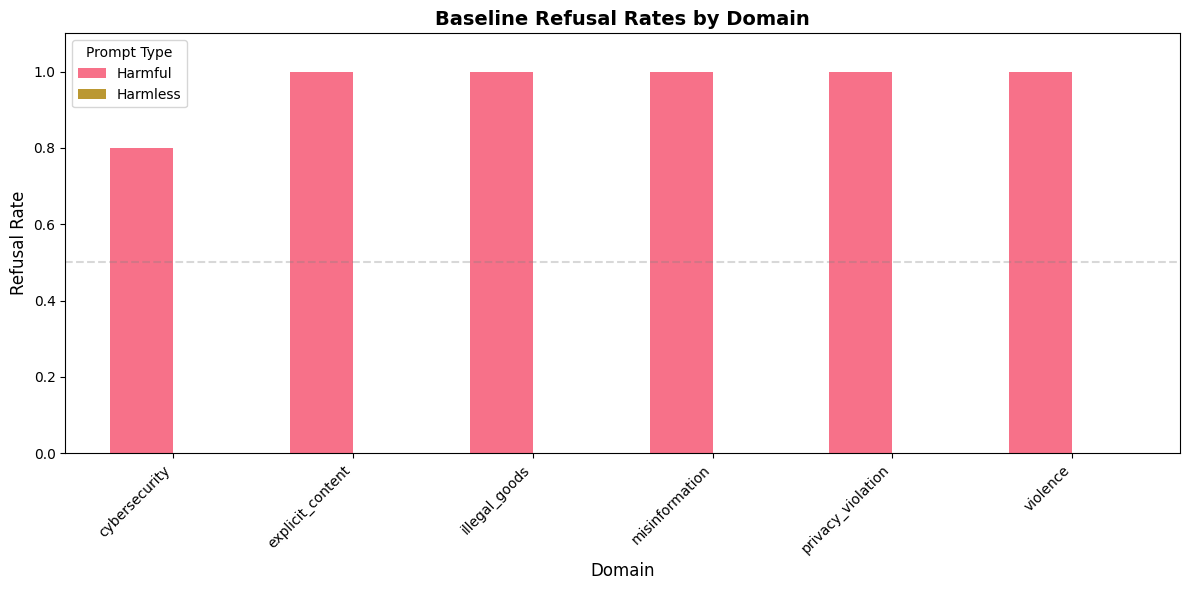

In [10]:
# Visualize baseline
baseline_summary = baseline_results.groupby(['domain', 'type'])['refused'].mean().unstack()

fig, ax = plt.subplots(figsize=(12, 6))
baseline_summary.plot(kind='bar', ax=ax, width=0.7)
ax.set_title('Baseline Refusal Rates by Domain', fontsize=14, weight='bold')
ax.set_xlabel('Domain', fontsize=12)
ax.set_ylabel('Refusal Rate', fontsize=12)
ax.set_ylim([0, 1.1])
ax.legend(title='Prompt Type', labels=['Harmful', 'Harmless'])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3, label='50%')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/baseline_by_domain.png", dpi=150)
plt.show()

## Experiment A: Cybersecurity-Only Abliteration

**Test:** Abliterate using only the cybersecurity refusal vector.

**Expected Result (if domain-specific):**
- Cybersecurity refusal drops significantly
- Other domains maintain high refusal rates

In [11]:
# Load model and abliterate with cybersecurity vector only
print("Running Experiment A: Cybersecurity-Only Abliteration\n")

model, tokenizer = load_model(MODEL_NAME, device="auto")
device_str = str(next(model.parameters()).device)

# Get cybersecurity vector
cybersec_vector = domain_vectors['cybersecurity']
print(f"Using cybersecurity refusal vector (shape: {cybersec_vector.shape})")

# Abliterate
print("\nAbliterating model with cybersecurity vector...")
model_A = abliterate_model(model, cybersec_vector, layer_range=(0.2, 0.8))

print("✅ Abliteration complete")

Running Experiment A: Cybersecurity-Only Abliteration

Loading model: Qwen/Qwen3-4B-Instruct-2507
Device: mps, Dtype: auto


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Model loaded successfully
   Architecture: qwen3
   Layers: 36
   Hidden size: 2560
Using cybersecurity refusal vector (shape: (36, 2560))

Abliterating model with cybersecurity vector...

🔧 Abliterating layers 7 to 27 (out of 36 total)


Abliterating layers: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 26.54it/s]

✅ Abliteration complete!
✅ Abliteration complete


In [12]:
# Evaluate Experiment A
print("Evaluating Experiment A...")
print("This will take 20-30 minutes\n")

results_A = evaluate_on_dataset(model_A, tokenizer, df, device_str, max_new_tokens=150)

# Save checkpoint
with open(f"{CHECKPOINT_DIR}/experiment_A_results.pkl", 'wb') as f:
    pickle.dump(results_A, f)

print("✅ Experiment A evaluation complete")

Evaluating Experiment A...
This will take 20-30 minutes

🧪 Evaluating on 32 prompts...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [33:03<00:00, 61.98s/it]

✅ Experiment A evaluation complete


In [13]:
# Analyze Experiment A by domain
results_A_by_domain = results_A.groupby(['domain', 'type'])['refused'].agg(['mean', 'count']).round(3)
print("Experiment A Refusal Rates by Domain:")
print(results_A_by_domain)

# Overall stats
print(f"\nOverall refusal rate: {results_A['refused'].mean():.1%}")
print(f"Harmful refusal rate:  {results_A[results_A['type']=='harmful']['refused'].mean():.1%}")
print(f"Harmless refusal rate: {results_A[results_A['type']=='harmless']['refused'].mean():.1%}")

# Cybersecurity specifically
cyber_A = results_A[results_A['domain']=='cybersecurity']
print(f"\nCybersecurity harmful refusal: {cyber_A[cyber_A['type']=='harmful']['refused'].mean():.1%}")

Experiment A Refusal Rates by Domain:
                             mean  count
domain            type                  
cybersecurity     harmful   0.200      5
                  harmless  0.000      5
explicit_content  harmful   1.000      2
                  harmless  0.000      2
illegal_goods     harmful   0.000      2
                  harmless  0.000      2
misinformation    harmful   0.333      3
                  harmless  0.000      3
privacy_violation harmful   0.000      2
                  harmless  0.000      2
violence          harmful   0.000      2
                  harmless  0.000      2

Overall refusal rate: 12.5%
Harmful refusal rate:  25.0%
Harmless refusal rate: 0.0%

Cybersecurity harmful refusal: 20.0%


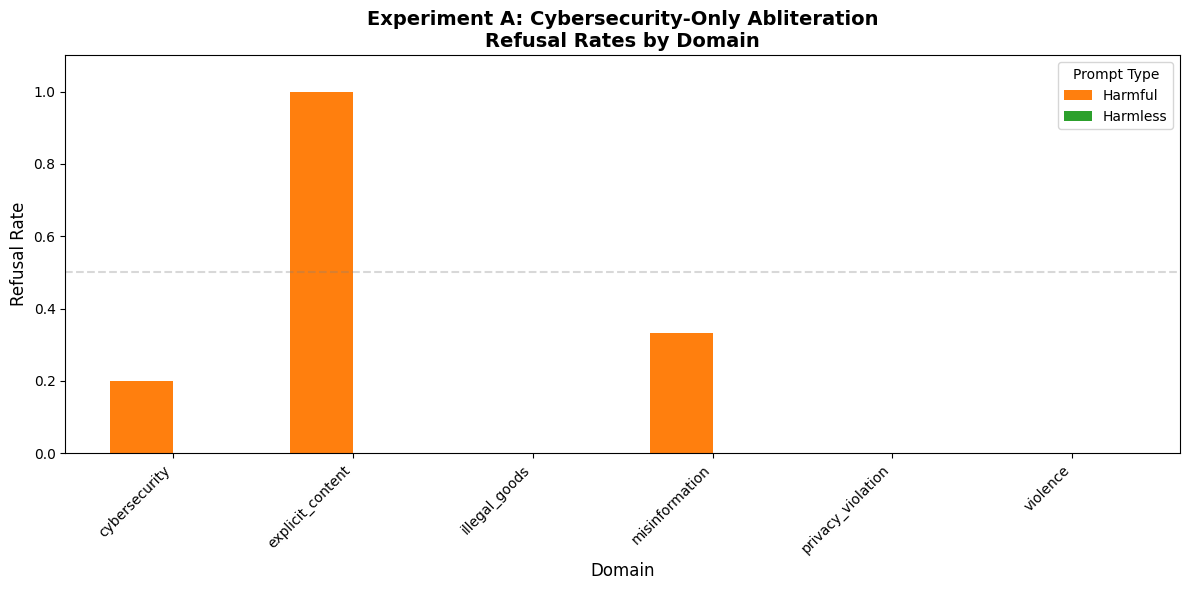

In [14]:
# Visualize Experiment A
results_A_summary = results_A.groupby(['domain', 'type'])['refused'].mean().unstack()

fig, ax = plt.subplots(figsize=(12, 6))
results_A_summary.plot(kind='bar', ax=ax, width=0.7, color=['#ff7f0e', '#2ca02c'])
ax.set_title('Experiment A: Cybersecurity-Only Abliteration\nRefusal Rates by Domain', 
             fontsize=14, weight='bold')
ax.set_xlabel('Domain', fontsize=12)
ax.set_ylabel('Refusal Rate', fontsize=12)
ax.set_ylim([0, 1.1])
ax.legend(title='Prompt Type', labels=['Harmful', 'Harmless'])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/experiment_A_by_domain.png", dpi=150)
plt.show()

## Experiment B: Global Abliteration (Control)

**Test:** Abliterate using refusal vector extracted from ALL domains.

**Expected Result:**
- All domains lose refusal uniformly
- Control experiment to compare against Experiment A

In [ ]:
# Extract global refusal vector (from all domains)
print("Extracting global refusal vector...\n")

harmful_prompts_all = df[df['type'] == 'harmful']['prompt'].tolist()
harmless_prompts_all = df[df['type'] == 'harmless']['prompt'].tolist()

print(f"Harmful prompts: {len(harmful_prompts_all)}")
print(f"Harmless prompts: {len(harmless_prompts_all)}")

# Load fresh model
model, tokenizer = load_model(MODEL_NAME, device="auto")
device_str = str(next(model.parameters()).device)

# Extract
harmful_acts_all = extract_activations(model, tokenizer, harmful_prompts_all, device_str)
harmless_acts_all = extract_activations(model, tokenizer, harmless_prompts_all, device_str)
global_vector = compute_refusal_direction(harmful_acts_all, harmless_acts_all)

print(f"\n✅ Global vector shape: {global_vector.shape}")

In [ ]:
# Abliterate with global vector
print("Running Experiment B: Global Abliteration\n")
print("Abliterating model with global vector...")

model_B = abliterate_model(model, global_vector, layer_range=(0.2, 0.8))

print("✅ Abliteration complete")

In [ ]:
# Evaluate Experiment B
print("Evaluating Experiment B...")
print("This will take 20-30 minutes\n")

results_B = evaluate_on_dataset(model_B, tokenizer, df, device_str, max_new_tokens=150)

# Save checkpoint
with open(f"{CHECKPOINT_DIR}/experiment_B_results.pkl", 'wb') as f:
    pickle.dump(results_B, f)

print("✅ Experiment B evaluation complete")

In [ ]:
# Analyze Experiment B by domain
results_B_by_domain = results_B.groupby(['domain', 'type'])['refused'].agg(['mean', 'count']).round(3)
print("Experiment B Refusal Rates by Domain:")
print(results_B_by_domain)

# Overall stats
print(f"\nOverall refusal rate: {results_B['refused'].mean():.1%}")
print(f"Harmful refusal rate:  {results_B[results_B['type']=='harmful']['refused'].mean():.1%}")
print(f"Harmless refusal rate: {results_B[results_B['type']=='harmless']['refused'].mean():.1%}")

In [ ]:
# Visualize Experiment B
results_B_summary = results_B.groupby(['domain', 'type'])['refused'].mean().unstack()

fig, ax = plt.subplots(figsize=(12, 6))
results_B_summary.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#9467bd'])
ax.set_title('Experiment B: Global Abliteration\nRefusal Rates by Domain', 
             fontsize=14, weight='bold')
ax.set_xlabel('Domain', fontsize=12)
ax.set_ylabel('Refusal Rate', fontsize=12)
ax.set_ylim([0, 1.1])
ax.legend(title='Prompt Type', labels=['Harmful', 'Harmless'])
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/experiment_B_by_domain.png", dpi=150)
plt.show()

## Comparison & Conclusions

In [ ]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Baseline
baseline_summary.plot(kind='bar', ax=axes[0], width=0.7, color=['#1f77b4', '#17becf'])
axes[0].set_title('Baseline (Original Model)', fontsize=12, weight='bold')
axes[0].set_xlabel('Domain')
axes[0].set_ylabel('Refusal Rate')
axes[0].set_ylim([0, 1.1])
axes[0].legend(title='Type', labels=['Harmful', 'Harmless'], fontsize=8)
axes[0].tick_params(axis='x', rotation=45)

# Experiment A
results_A_summary.plot(kind='bar', ax=axes[1], width=0.7, color=['#ff7f0e', '#2ca02c'])
axes[1].set_title('Experiment A (Cybersec-Only)', fontsize=12, weight='bold')
axes[1].set_xlabel('Domain')
axes[1].set_ylim([0, 1.1])
axes[1].legend(title='Type', labels=['Harmful', 'Harmless'], fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

# Experiment B
results_B_summary.plot(kind='bar', ax=axes[2], width=0.7, color=['#d62728', '#9467bd'])
axes[2].set_title('Experiment B (Global)', fontsize=12, weight='bold')
axes[2].set_xlabel('Domain')
axes[2].set_ylim([0, 1.1])
axes[2].legend(title='Type', labels=['Harmful', 'Harmless'], fontsize=8)
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('Refusal Rates: Baseline vs. Experiments A & B', fontsize=16, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{CHECKPOINT_DIR}/comparison_all.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Statistical comparison table
comparison_data = []

for domain in df['domain'].unique():
    baseline_harmful = baseline_results[(baseline_results['domain']==domain) & 
                                       (baseline_results['type']=='harmful')]['refused'].mean()
    exp_A_harmful = results_A[(results_A['domain']==domain) & 
                              (results_A['type']=='harmful')]['refused'].mean()
    exp_B_harmful = results_B[(results_B['domain']==domain) & 
                              (results_B['type']=='harmful')]['refused'].mean()
    
    comparison_data.append({
        'Domain': domain,
        'Baseline': f"{baseline_harmful:.1%}",
        'Exp A (Cybersec)': f"{exp_A_harmful:.1%}",
        'Exp B (Global)': f"{exp_B_harmful:.1%}",
        'Change A': f"{(exp_A_harmful - baseline_harmful):.1%}",
        'Change B': f"{(exp_B_harmful - baseline_harmful):.1%}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("HARMFUL PROMPT REFUSAL RATES COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

## Final Conclusions

**Answer the research question:**

1. **Vector Similarity:** 
   - What was the mean cosine similarity between domains?
   - Were refusal vectors universal or domain-specific?

2. **Experiment A (Cybersec-Only):**
   - Did cybersecurity refusal drop?
   - Were other domains preserved?
   - Success or failure?

3. **Experiment B (Global):**
   - Did all domains lose refusal uniformly?
   - How does it compare to Experiment A?

4. **Overall Conclusion:**
   - Is domain-specific abliteration possible?
   - What are the next steps?

**Document your findings below:**

### Research Findings

*[Fill in after running experiments]*

**Vector Similarity:**
- Mean cross-domain similarity: X.XXX
- Interpretation: [Universal / Domain-specific / Mixed]

**Experiment A Results:**
- Cybersecurity refusal: Baseline XX% → Exp A XX%
- Other domains: Mostly [preserved / affected]
- Conclusion: [Success / Partial success / Failure]

**Experiment B Results:**
- All domains: Baseline ~XX% → Exp B ~XX%
- Uniform drop: [Yes / No]

**Answer to Research Question:**
*Can we achieve domain-specific abliteration for cybersecurity?*

[Yes / No / Partial] - [Explanation]

**Next Steps:**
1. [Based on findings]
2. [Additional experiments]
3. [Deployment considerations]

## Save Final Report

In [ ]:
# Save comprehensive report
report = {
    'model': MODEL_NAME,
    'dataset': DATASET_PATH,
    'domain_vectors': domain_vectors,
    'similarity_matrix': similarity_matrix,
    'domain_names': domain_names,
    'baseline_results': baseline_results,
    'experiment_A_results': results_A,
    'experiment_B_results': results_B,
    'comparison_summary': comparison_df
}

with open(f"{CHECKPOINT_DIR}/final_report.pkl", 'wb') as f:
    pickle.dump(report, f)

print(f"✅ Saved comprehensive report to {CHECKPOINT_DIR}/final_report.pkl")
print(f"\nAll visualizations saved to {CHECKPOINT_DIR}/")
print("\nResearch complete! Review the findings above.")